# Machine Learning Engineer Nanodegree
## Capstone Data Exploration, examine data one by one

In [1]:
# Import libraries necessary for this project
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gc
import seaborn as sns
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
if not os.path.exists('figs'):
    os.mkdir('figs')

# Pretty display for notebooks
%matplotlib inline


In [2]:
# Load raw dataset
prop_data = pd.read_csv('data/properties_2016.csv', header=0)
error_data = pd.read_csv('data/train_2016_v2.csv', header=0)

In [3]:
# get error data transaction date to month
error_data['sale_month'] = error_data['transactiondate'].apply(lambda x: x.split('-')[1])  
error_data['abs_logerror'] = np.abs(error_data['logerror'])
# merge to train data set
train_data = error_data.merge(prop_data, on='parcelid', how='left')
train_data.to_csv('data/train_data_merged.csv', index=False)

In [4]:
train_data = pd.read_csv('data/train_data_merged.csv', header=0)

In [5]:
# shape of data
n_total = prop_data.shape[0]
n_train = train_data.shape[0]
print('total_data shape: ' + str(prop_data.shape))
print('train_data shape: ' + str(train_data.shape))

total_data shape: (2985217, 58)
train_data shape: (90275, 62)


In [66]:
# util functions
def cat_num_to_str(col_name):
    """for numeric-like categorical varible, transform to string, keep nan"""
    if not prop_data[col_name].dtype == 'O':
        prop_data[col_name] = prop_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)
    if not train_data[col_name].dtype == 'O':
        train_data[col_name] = train_data[col_name].apply(lambda x: str(int(x)) if not np.isnan(x) else np.nan)


def mark_flag_col(col_name):
    """mark bool for numerical columns, mark True for val > 0, and False otherwise (include NaN)"""
    if not prop_data[col_name].dtype == 'O':
        prop_data_marks_true = prop_data[col_name] >= 0.5
        prop_data.loc[prop_data.index[prop_data_marks_true], col_name] = 'TRUE'
        prop_data.loc[prop_data.index[~prop_data_marks_true], col_name] = 'FALSE'
    if not train_data[col_name].dtype == 'O':
        train_data_marks_true = train_data[col_name] >= 0.5
        train_data.loc[train_data.index[train_data_marks_true], col_name] = 'TRUE'
        train_data.loc[train_data.index[~train_data_marks_true], col_name] = 'FALSE'

        
def cat_feature_analysis(col_name):
    """analysis of categorical feature, comparing number of unique appeared values between train_data and prop_data, with NaN removed.
       For those values appear in train but not in prop, need to properly handle for prop in prediction."""    
    prop_col_no_nan = prop_data[col_name][~prop_data[col_name].isnull()]
    train_col_no_nan = train_data[col_name][~train_data[col_name].isnull()]
    vals_prop = np.sort(prop_col_no_nan.unique())
    vals_train = np.sort(train_col_no_nan.unique())
    if len(vals_train) < 15:
        print('vals from train_data: %s' % ', '.join([str(v) for v in vals_train]))
    val_prop_de_train = set(vals_prop) - set(vals_train)
    print('n_vals from train_data: %d' % len(vals_train))
    if val_prop_de_train:
        if len(val_prop_de_train) < 15:
            print('vals in prop not in train: %s' % ', '.join([str(v) for v in sorted(list(val_prop_de_train))]))
        print('n_vals in prop not in train: %d' % len(val_prop_de_train))
        # summarize ratio of not appeared-in-training value samples in total porpulation
        n_sample = np.sum(np.array([i in val_prop_de_train for i in prop_data[col_name]]))
        print('ratio sample with val in prop not in train: %4.6f' % (n_sample / float(n_total)))
    else:
        print('prop and train vals set consistent')
    return val_prop_de_train 


def missing_ratio(col_name):
    """compare missing rate in prop data and train data. A good feature should have similar ratio in both training and total population."""
    print('missing ratio prop: %4.4f' % (np.sum(prop_data[col_name].isnull()) / float(n_total)))
    print('missing ratio train: %4.4f' % (np.sum(train_data[col_name].isnull()) / float(n_train)))
    

def visual_analysis_num(col_name):
    """view relationship to error for numerical variables, summarize for NaN separately"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    col_name_use = RENAMING_MAP[col_name]
    sns.kdeplot(train_data[col_name], bw=0.5, ax=ax1).set_title('density')  # 1, density plot
    fit_logerror = lowess(train_data['logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_logerror, fit_reg=False, ax=ax2).set_title('against logerror')  # 2, logerror
    fit_abs_logerror = lowess(train_data['abs_logerror'], train_data[col_name], return_sorted =False, it=0)
    sns.regplot(train_data[col_name], fit_abs_logerror, fit_reg=False, ax=ax3).set_title('against abs_logerror')  # 3, abs_logerror
    fig.suptitle('exploration for %s' % RENAMING_MAP[col_name])
    fig.show()
    fig.savefig('figs/explore_%s.png' % RENAMING_MAP[col_name])


def visual_analysis_cat(col_name):
    """view relationship to error for categorical variables"""
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.countplot(train_data[col_name], ax=ax1).set_title('density')  # 1, density plot
    sns.barplot(x=col_name, y='logerror', data=train_data, ax=ax2).set_title('against logerror')  # 2, logerror
    sns.barplot(x=col_name, y='abs_logerror', data=train_data, ax=ax3).set_title('against abs logerror')  # 3, logerror
    fig.suptitle('exploration for %s' % RENAMING_MAP[col_name])
    fig.show()
    fig.savefig('figs/explore_%s.png' % RENAMING_MAP[col_name])

In [7]:
# global consts
RENAMING_MAP = {}  # map from old name to new name, for column rename, getting more meaningful names
KEEP_FEATURE = set()

### airconditioningtypeid

Description: Type of cooling system present in the home (if any). And further description gives

| Type ID  | Description  |
|----------|---|
|1	     |Central|
|2	     |Chilled Water|
|3	     |Evaporative Cooler|
|4	     |Geo Thermal|
|5	     |None|
|6	     |Other|
|7	     |Packaged AC Unit|
|8	     |Partial|
|9	     |Refrigeration|
|10	     |Ventilation|
|11	     |Wall Unit|
|12	     |Window Unit|
|13	     |Yes|

From where we can see it is a categorical variable. And None is already included in description, so NaN is trully missing.

Meanwhile, name is too complicated, rename to 'type_air_conditioning'.

In [8]:
RENAMING_MAP['airconditioningtypeid'] = 'type_air_conditioning'
print('data type:' + str(prop_data['airconditioningtypeid'].dtype))
cat_num_to_str('airconditioningtypeid')
cat_feature_analysis('airconditioningtypeid')
missing_ratio('airconditioningtypeid')

data type:float64
vals from train_data: 1, 11, 13, 3, 5, 9
n_vals from train_data: 6
vals in prop not in train: 12
n_vals in prop not in train: 1
ratio sample with val in prop not in train: 0.000020
missing ratio prop: 0.7282
missing ratio train: 0.6812


num type 12 air conditioning in prop data: 0


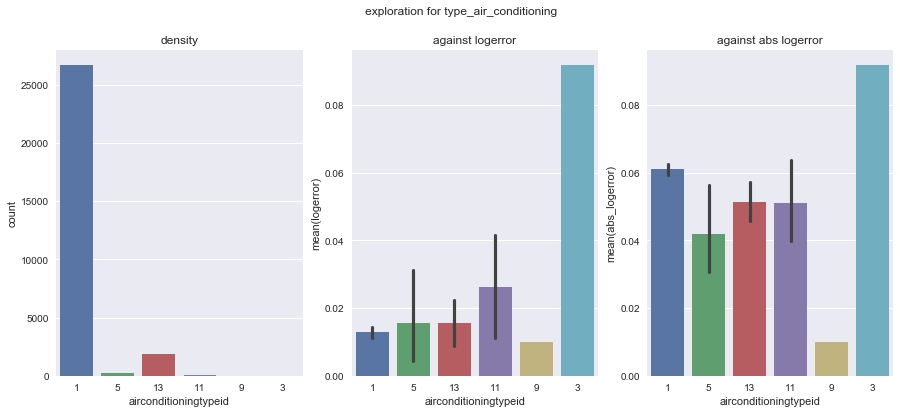

In [9]:
# setting 12 in prop data to nan
prop_data['airconditioningtypeid'].loc[prop_data['airconditioningtypeid'].index[prop_data['airconditioningtypeid'] == '12']] = np.nan
# it gives me a warning, let's make sure it is indeed succussfully get value set
print('num type 12 air conditioning in prop data: %d' % np.sum(prop_data['airconditioningtypeid'] == '12'))
# missing ratio looks high. keep it for the moment
KEEP_FEATURE.add('airconditioningtypeid')
visual_analysis_cat('airconditioningtypeid')

### architecturalstyletypeid

Description:  Architectural style of the home (i.e. ranch, colonial, split-level, etc…). And further description gives

| Type ID  | Description  |
|----------|---|
|1	| A-Frame |
|2	| Bungalow |
|3	| Cape Cod |
|4	| Cottage |
|5	| Colonial |
|6	| Custom |
|7	| Contemporary |
|8	| Conventional |
|9	| Dome |
|10	| French Provincial |
|11	| Georgian |
|12	| High Rise |
|13	| Historical |
|14	| Log Cabin/Rustic |
|15	| Mediterranean |
|16	| Modern |
|17	| Mansion |
|18	| English |
|19	| Other |
|20	| Prefab |
|21	| Ranch/Rambler |
|22	| Raised Ranch |
|23	| Spanish |
|24	| Traditional |
|25	| Tudor |
|26	| Unfinished/Under Construction |
|27	| Victorian |

It is also a categorical variable. And since is a style, so NaN is trully missing.

Meanwhile, rename to 'type_architectural_style'.

In [10]:
RENAMING_MAP['architecturalstyletypeid'] = 'type_architectural_style'
print('data type:' + str(prop_data['architecturalstyletypeid'].dtype))
cat_num_to_str('architecturalstyletypeid')
cat_feature_analysis('architecturalstyletypeid')
missing_ratio('architecturalstyletypeid')

data type:float64
vals from train_data: 10, 2, 21, 3, 7, 8
n_vals from train_data: 6
vals in prop not in train: 27, 5
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000007
missing ratio prop: 0.9980
missing ratio train: 0.9971


In [11]:
prop_data['architecturalstyletypeid'].loc[prop_data['architecturalstyletypeid'].index[prop_data['architecturalstyletypeid'].apply(lambda x: x in {'27', '5'})]] = np.nan

missing rate is too high, drop the feature. But still clean the prop data.

### basementsqft

Description:  Finished living area below or partially below ground level. So it is a numerical value. Rename it to 'area_base_finished'.

In [12]:
RENAMING_MAP['basementsqft'] = 'area_base_finished'
missing_ratio('basementsqft')

missing ratio prop: 0.9995
missing ratio train: 0.9995


missing rate is too high, drop the feature

### bathroomcnt

Description: Number of bathrooms in home including fractional bathrooms. It includes fraction, so clearly numerical. Also, since explained in FAQ, there two versions of bath room count, one from assessor and one from Zillow internally, rename to 'num_bathroom_assessor'.

In [13]:
RENAMING_MAP['bathroomcnt'] = 'num_bathroom_assessor'
missing_ratio('bathroomcnt')

missing ratio prop: 0.0038
missing ratio train: 0.0000


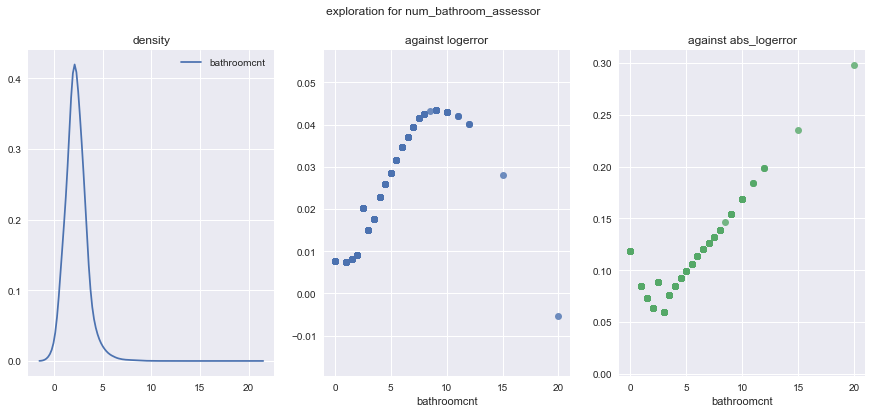

In [14]:
# very high quality feature. Let's further examine its relationship to errors.
visual_analysis_num('bathroomcnt')
KEEP_FEATURE.add('bathroomcnt')
# NOTE training without missing, need to fill missing for prop data. For cnt feature, let's fill with mode
prop_data['bathroomcnt'].fillna(prop_data['bathroomcnt'].mode().values[0], inplace=True)

### calculatedbathnbr

Description: Number of bathrooms in home including fractional bathroom. Same as feature above but evaluated by Zillow internally, rename to 'num_bathroom_zillow'.

In [15]:
RENAMING_MAP['calculatedbathnbr'] = 'num_bathroom_zillow'
missing_ratio('calculatedbathnbr')

missing ratio prop: 0.0432
missing ratio train: 0.0131


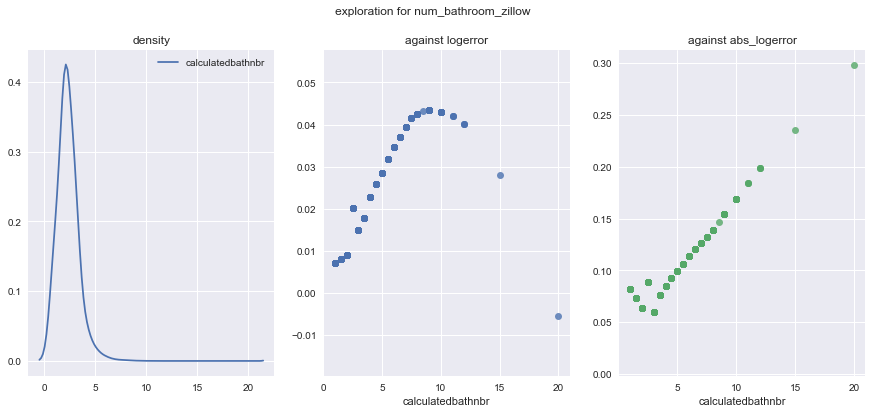

In [16]:
# also very high quality. Let's further examine its relationship to errors, as expected, pattern is similar to that of assessor version.
visual_analysis_num('calculatedbathnbr')
KEEP_FEATURE.add('calculatedbathnbr')

### bedroomcnt

Description:  Number of bedrooms in home. Very intuitive, rename to 'num_bedroom'.

In [17]:
RENAMING_MAP['bedroomcnt'] = 'num_bedroom'
missing_ratio('bedroomcnt')

missing ratio prop: 0.0038
missing ratio train: 0.0000


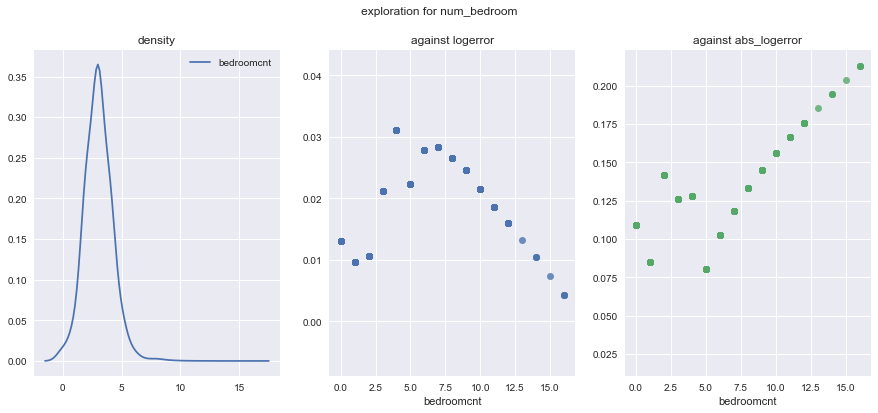

In [18]:
# low missing rate, do visual analysis.
visual_analysis_num('bedroomcnt')
KEEP_FEATURE.add('bedroomcnt')
# NOTE training without missing, need to fill missing for prop data. For cnt feature, let's fill with mode
prop_data['bedroomcnt'].fillna(prop_data['bedroomcnt'].mode().values[0], inplace=True)

### buildingclasstypeid

Description: The building framing type (steel frame, wood frame, concrete/brick). Detailed description too long, put is as bullets.

- 1: Buildings having fireproofed structural steel frames carrying all wall, floor and roof loads. Wall, floor and roof structures are built of non-combustible materials.
- 2: Buildings having fireproofed reinforced concrete frames carrying all wall floor and roof loads which are all non-combustible.
- 3: Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.
- 4: Buildings having wood or wood and steel frames
- 5: Specialized buildings that do not fit in any of the above categories

Categorical, NaN should be real missing, rename to 'type_building_framing'

In [19]:
RENAMING_MAP['buildingclasstypeid'] = 'type_building_framing'
print('data type:' + str(prop_data['buildingclasstypeid'].dtype))
cat_num_to_str('buildingclasstypeid')
cat_feature_analysis('buildingclasstypeid')
missing_ratio('buildingclasstypeid')

data type:float64
vals from train_data: 4
n_vals from train_data: 1
vals in prop not in train: 1, 2, 3, 5
n_vals in prop not in train: 4
ratio sample with val in prop not in train: 0.001127
missing ratio prop: 0.9958
missing ratio train: 0.9998


In [20]:
prop_data['buildingclasstypeid'].loc[prop_data['buildingclasstypeid'].index[prop_data['buildingclasstypeid'] == '4']] = np.nan

missing rate is too high, drop the feature, still clean prop data for good.

### buildingqualitytypeid

Overall assessment of condition of the building from best (lowest) to worst (highest). Although there is a 'typeid' in the name, it is not really categorical, rank between the values has actual meaning, take it as numerical. Rename to 'rank_building_quality'

In [21]:
RENAMING_MAP['buildingqualitytypeid'] = 'rank_building_quality'
missing_ratio('buildingqualitytypeid')

missing ratio prop: 0.3506
missing ratio train: 0.3646


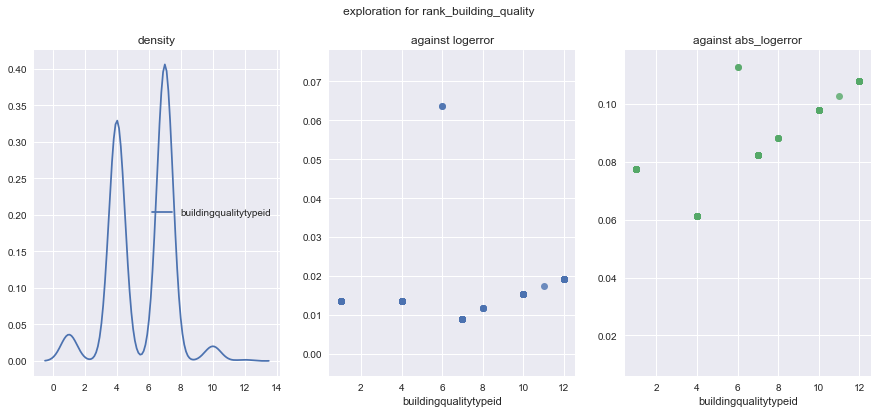

In [22]:
# affordable missing rate. Do visual analysis
visual_analysis_num('buildingqualitytypeid')
KEEP_FEATURE.add('buildingqualitytypeid')

### decktypeid

Description: Type of deck (if any) present on parcel. There is no detailed description for it. '(if any)' seems NaN means there is no deck. Rename to 'type_deck'.

In [23]:
RENAMING_MAP['decktypeid'] = 'type_deck'
print('data type:' + str(prop_data['decktypeid'].dtype))
cat_num_to_str('decktypeid')
cat_feature_analysis('decktypeid')
missing_ratio('decktypeid')

data type:float64
vals from train_data: 66
n_vals from train_data: 1
prop and train vals set consistent
missing ratio prop: 0.9943
missing ratio train: 0.9927


missing rate too high, cannot even use NaN vs. non_NaN as feature.

### finishedfloor1squarefeet

Description: Size of the finished living area on the first (entry) floor of the home. Again, apparently a numerical feature. Zillow version, rename to 'area_firstfloor_zillow'.

In [24]:
RENAMING_MAP['finishedfloor1squarefeet'] = 'area_firstfloor_zillow'
missing_ratio('finishedfloor1squarefeet')

missing ratio prop: 0.9321
missing ratio train: 0.9241


missing rate too high drop the feature.

### calculatedfinishedsquarefeet

Description: Calculated total finished living area of the home. Zillow version of finishedfloor1squarefeet. Rename it to 'area_living_finished_calc'.

In [25]:
RENAMING_MAP['calculatedfinishedsquarefeet'] = 'area_living_finished_calc'
missing_ratio('calculatedfinishedsquarefeet')

missing ratio prop: 0.0186
missing ratio train: 0.0073


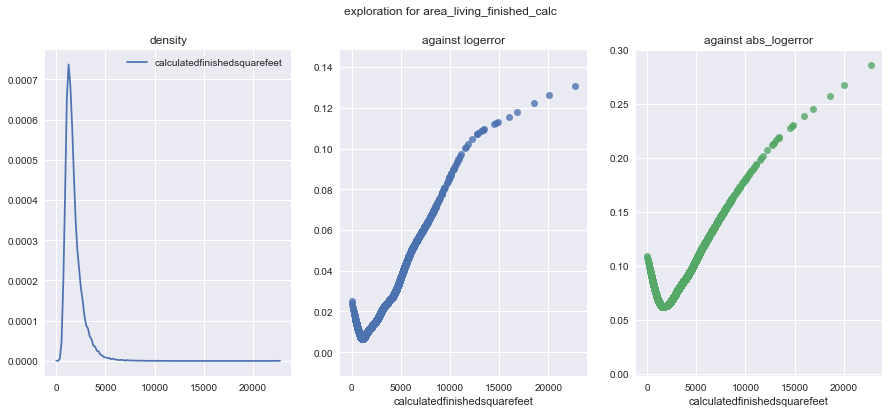

In [26]:
# missing ratio is very low, keep it.
visual_analysis_num('calculatedfinishedsquarefeet')
KEEP_FEATURE.add('calculatedfinishedsquarefeet')

### finishedsquarefeet12

Description: Finished living area. A specific type of measuring of living area. Rename to 'area_living_type_12'

In [27]:
RENAMING_MAP['finishedsquarefeet12'] = 'area_living_type_12'
missing_ratio('finishedsquarefeet12')

missing ratio prop: 0.0925
missing ratio train: 0.0518


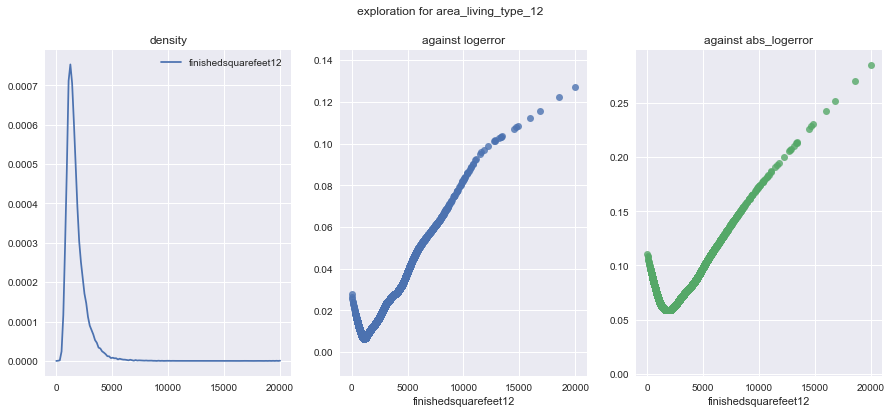

In [28]:
# missing ratio is very low, keep it.
visual_analysis_num('finishedsquarefeet12')
KEEP_FEATURE.add('finishedsquarefeet12')

### finishedsquarefeet13

Description: Perimeter living area. A specific type of measuring of living area. Rename to 'area_living_type_13'

In [29]:
RENAMING_MAP['finishedsquarefeet13'] = 'area_living_type_13'
missing_ratio('finishedsquarefeet13')

missing ratio prop: 0.9974
missing ratio train: 0.9996


high missing rate, drop it.

### finishedsquarefeet15

Description: Total area. A specific type of measuring of living area. Rename to 'area_living_type_15'

In [30]:
RENAMING_MAP['finishedsquarefeet15'] = 'area_living_type_15'
missing_ratio('finishedsquarefeet15')

missing ratio prop: 0.9361
missing ratio train: 0.9605


high missing rate, drop it.

### finishedsquarefeet50

Description: Size of the finished living area on the first (entry) floor of the home. Another first floor living area. Assessor version, rename to 'area_firstfloor_assessor'

In [31]:
RENAMING_MAP['finishedsquarefeet50'] = 'area_firstfloor_assessor'
missing_ratio('finishedsquarefeet50')

missing ratio prop: 0.9321
missing ratio train: 0.9241


high missing rate, drop it.

### finishedsquarefeet6

Description: Base unfinished and finished area. Specific type of living area. Rename to 'area_living_type_6'

In [32]:
RENAMING_MAP['finishedsquarefeet6'] = 'area_living_type_6'
missing_ratio('finishedsquarefeet6')

missing ratio prop: 0.9926
missing ratio train: 0.9953


high missing rate, drop it.

### fips

Description: eral Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details. Categorical, rename to 'code_ips'.

In [33]:
RENAMING_MAP['fips'] = 'code_ips'
print('data type:' + str(prop_data['fips'].dtype))
cat_num_to_str('fips')
cat_feature_analysis('fips')
missing_ratio('fips')

data type:float64
vals from train_data: 6037, 6059, 6111
n_vals from train_data: 3
prop and train vals set consistent
missing ratio prop: 0.0038
missing ratio train: 0.0000


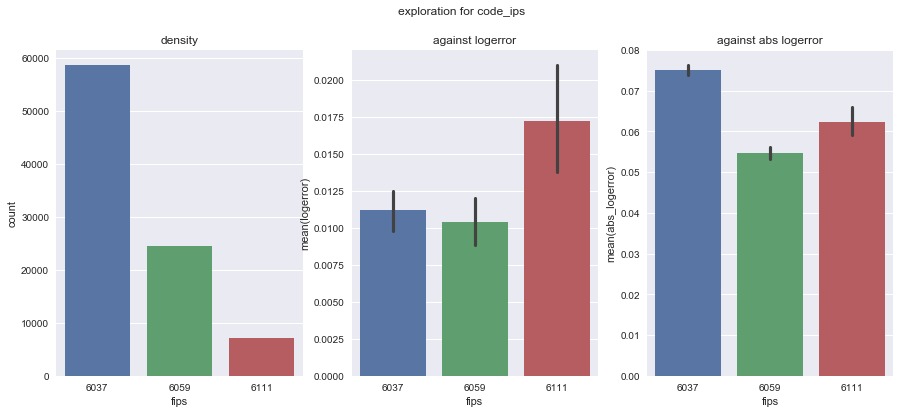

In [34]:
# low missing rate, keep it.
visual_analysis_cat('fips')
KEEP_FEATURE.add('fips')
# NOTE training without missing, need to fill missing for prop data. For cnt feature, let's fill with mode
prop_data['fips'].fillna(prop_data['fips'].mode().values[0], inplace=True)

### fireplacecnt

Description: Number of fireplaces in a home (if any). '(if any)' means NaN shoud actually be handled as 0. it is important, as xgboost and lightGBM have special handling for NaN. Rename to 'num_fireplace'.

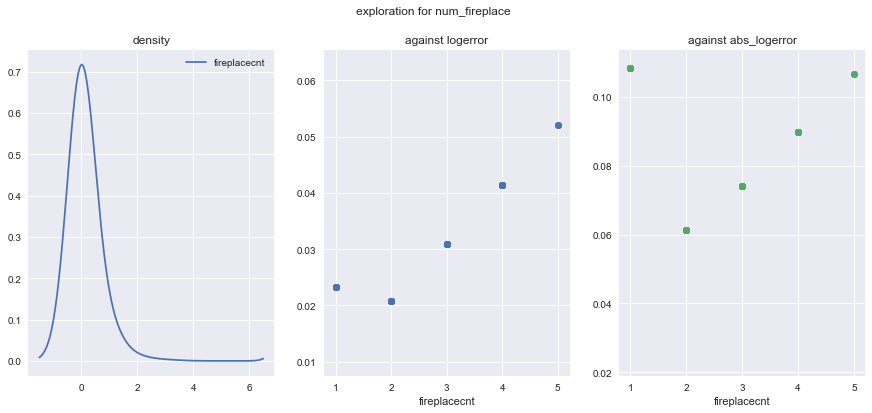

In [35]:
RENAMING_MAP['fireplacecnt'] = 'num_fireplace'
# impute NaN as 0. 
prop_data['fireplacecnt'].fillna(0, inplace=True)
train_data['fireplacecnt'].fillna(0, inplace=True)
# no need to view missing ratio, directly add to feature
KEEP_FEATURE.add('fireplacecnt')
visual_analysis_num('fireplacecnt')

### fullbathcnt

Description: Number of full bathrooms (sink, shower + bathtub, and toilet) present in home. There is no 'is any' there, but there is no zero in the data. Meanwhile, we have 'bath room count' feature, which had no missing value. Below analysis shows that NaN full bathroom are not all having 0 bathroom, let's impute it this way: 1, n_bathroom is fraction, take floor; 2, n_bathroom is int, reduce by 1. And rename to 'num_fullbath'.

min num_full_bath in train: 1
range of num_bath for NaN fullbath: min = 0, max = 4, num_nan= 0


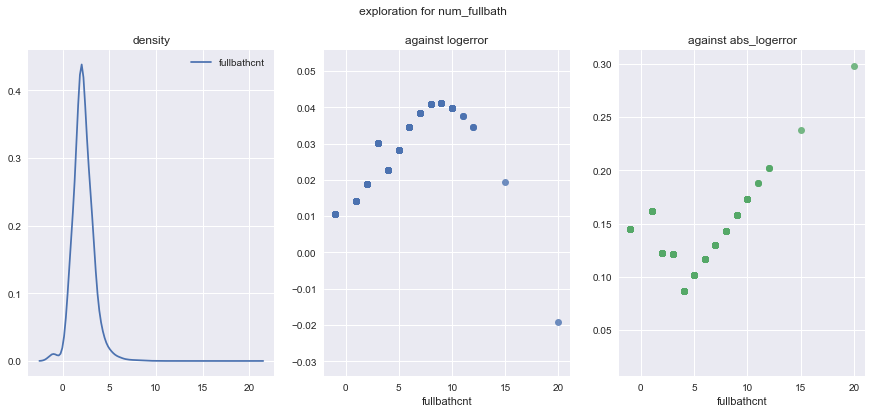

In [36]:
import math
print('min num_full_bath in train: %d' % np.min(train_data['fullbathcnt'].dropna()))
bathroomcnt_subset = train_data['bathroomcnt'].loc[train_data.index.values[train_data['fullbathcnt'].isnull()]]
bathroomcnt_subset_n_nan = np.sum(bathroomcnt_subset.isnull())
bathroomcnt_subset_nonan = bathroomcnt_subset.dropna()
bathroomcnt_subset_nonan_max = bathroomcnt_subset_nonan.max()
bathroomcnt_subset_nonan_min = bathroomcnt_subset_nonan.min()
print('range of num_bath for NaN fullbath: min = %d, max = %d, num_nan= %d' % (bathroomcnt_subset_nonan_min, bathroomcnt_subset_nonan_max, bathroomcnt_subset_n_nan))

RENAMING_MAP['fullbathcnt'] = 'num_fullbath'
# special NaN impute:
def nan_impute_fullbathcnt(data):
    null_idx = data.index[data['fullbathcnt'].isnull()]
    fill_val = data['bathroomcnt'][null_idx].copy()
    fill_val_raw = fill_val.copy()
    fill_val_raw_floor = fill_val_raw.apply(math.floor)
    int_idx = np.abs(fill_val_raw.values - fill_val_raw_floor.values) < 1e-12
    fill_val[int_idx] = fill_val_raw[int_idx] - 1
    fill_val[~int_idx] = fill_val_raw_floor[~int_idx]
    data.loc[null_idx, 'fullbathcnt'] = fill_val
    return data
    
prop_data = nan_impute_fullbathcnt(prop_data)
train_data = nan_impute_fullbathcnt(train_data)
# no need to view missing ratio, directly add to feature
KEEP_FEATURE.add('fullbathcnt')
visual_analysis_num('fullbathcnt')

### garagecarcnt

Description:  Total number of garages on the lot including an attached garage. Have 0 in data, leave NaN as it is. Rename to 'num_garage'.

In [37]:
RENAMING_MAP['garagecarcnt'] = 'num_garage'
missing_ratio('garagecarcnt')

missing ratio prop: 0.7041
missing ratio train: 0.6684


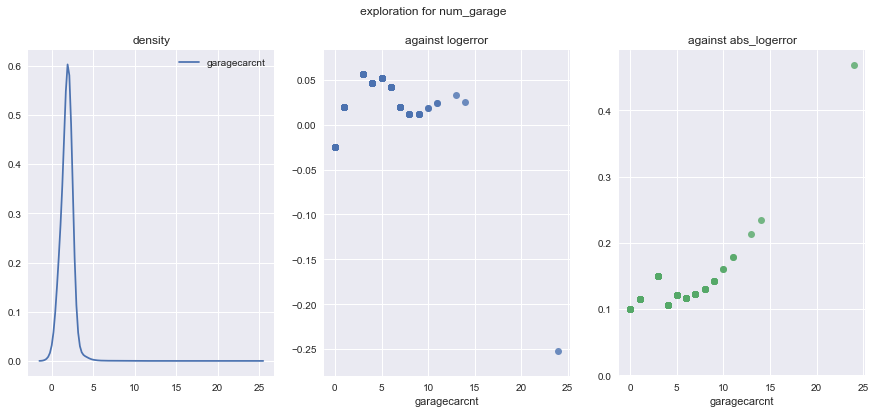

In [38]:
# missing ratio looks high. keep it for the moment
KEEP_FEATURE.add('garagecarcnt')
visual_analysis_num('garagecarcnt')

### garagetotalsqft

Description: Total number of square feet of all garages on lot including an attached garage. A quick view on the data looks strange, besides NaN, we have 0 values for this field, while most of them do not corrsponds to 0 count. Let's mark those zero area with non-zero count as NaN. Rename to 'area_garage'.

In [39]:
RENAMING_MAP['garagetotalsqft'] = 'area_garage'
def zero_impute_area_garage(data):
    target_idx = data.index[np.abs(data['garagetotalsqft'] - 0) < 1e-12]
    nan_idx = target_idx[data.loc[target_idx, 'garagecarcnt'] > 0]
    data.loc[nan_idx, 'garagetotalsqft'] = np.nan
zero_impute_area_garage(prop_data)
zero_impute_area_garage(train_data)
missing_ratio('garagetotalsqft')

missing ratio prop: 0.7654
missing ratio train: 0.7672


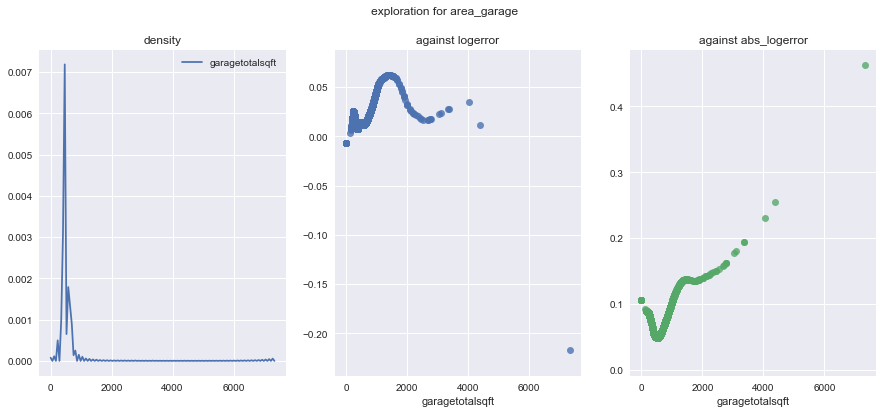

In [40]:
# missing ratio looks high. keep it for the moment
KEEP_FEATURE.add('garagetotalsqft')
visual_analysis_num('garagetotalsqft')

### hashottuborspa

Description:  Does the home have a hot tub or spa. This is a bool, and value only has TRUE and NaN, so seems reasonable to put NaN as False and use this feature as category. Rename to 'flag_spa_zillow'.

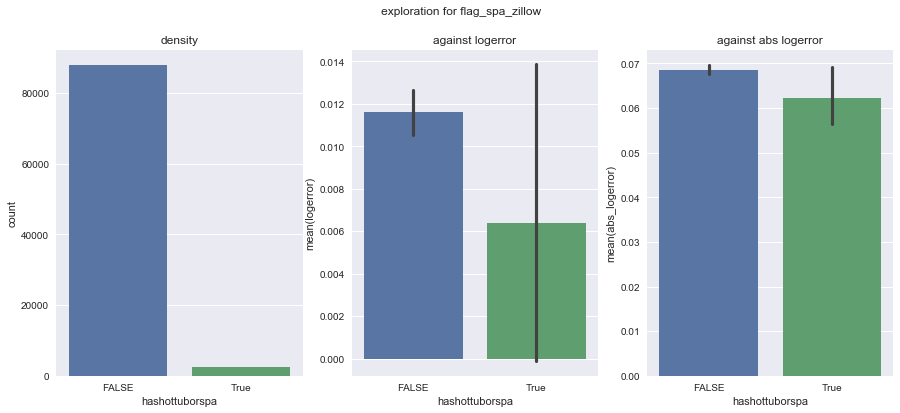

In [41]:
RENAMING_MAP['hashottuborspa'] = 'flag_spa_zillow'
prop_data.loc[prop_data.index[prop_data['hashottuborspa'].isnull()], 'hashottuborspa'] = 'FALSE'
train_data.loc[train_data.index[train_data['hashottuborspa'].isnull()], 'hashottuborspa'] = 'FALSE'
# no missing rate
KEEP_FEATURE.add('hashottuborspa')
visual_analysis_cat('hashottuborspa')

### heatingorsystemtypeid

Description: Type of home heating system. Details of each type:

| Type ID  | Description  |
|----------|---|
|1	|Baseboard|
|2	|Central|
|3	|Coal|
|4	|Convection|
|5	|Electric|
|6	|Forced air|
|7	|Floor/Wall|
|8	|Gas|
|9	|Geo Thermal|
|10	|Gravity|
|11	|Heat Pump|
|12	|Hot Water|
|13	|None|
|14	|Other|
|15	|Oil|
|16	|Partial|
|17	|Propane|
|18	|Radiant|
|19	|Steam|
|20	|Solar|
|21	|Space/Suspended|
|22	|Vent|
|23	|Wood Burning|
|24	|Yes|
|25	|Zone|

Since None is already in there, should take NaN as true missing. Rename it to 'type_heating_system'

In [42]:
RENAMING_MAP['heatingorsystemtypeid'] = 'type_heating_system'
print('data type:' + str(prop_data['heatingorsystemtypeid'].dtype))
cat_num_to_str('heatingorsystemtypeid')
cat_feature_analysis('heatingorsystemtypeid')
missing_ratio('heatingorsystemtypeid')

data type:float64
vals from train_data: 1, 10, 11, 12, 13, 14, 18, 2, 20, 24, 6, 7
n_vals from train_data: 12
vals in prop not in train: 19, 21
n_vals in prop not in train: 2
ratio sample with val in prop not in train: 0.000001
missing ratio prop: 0.3949
missing ratio train: 0.3788


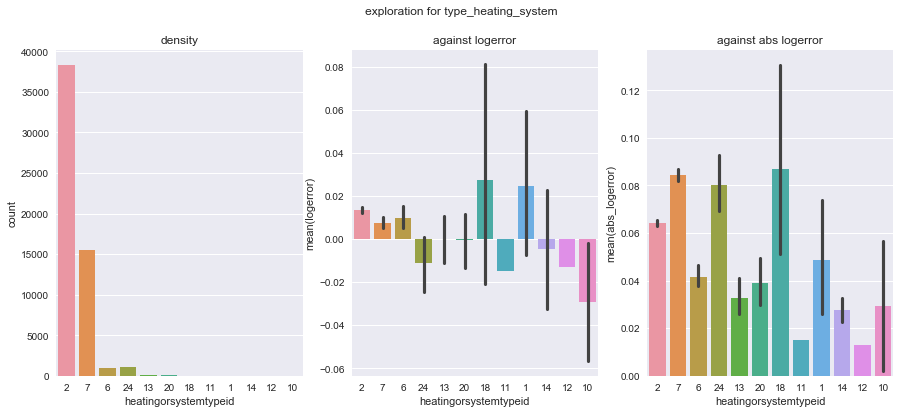

In [45]:
# missing rate is not too high, and from figure below, it has good discrimination power of logerrors, let's keep it.
prop_data['heatingorsystemtypeid'].loc[prop_data['heatingorsystemtypeid'].index[prop_data['heatingorsystemtypeid'].apply(lambda x: x in {'19', '21'})]] = np.nan
KEEP_FEATURE.add('heatingorsystemtypeid')
visual_analysis_cat('heatingorsystemtypeid')

### latitude

Description: Latitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model.

missing ratio prop: 0.0038
missing ratio train: 0.0000


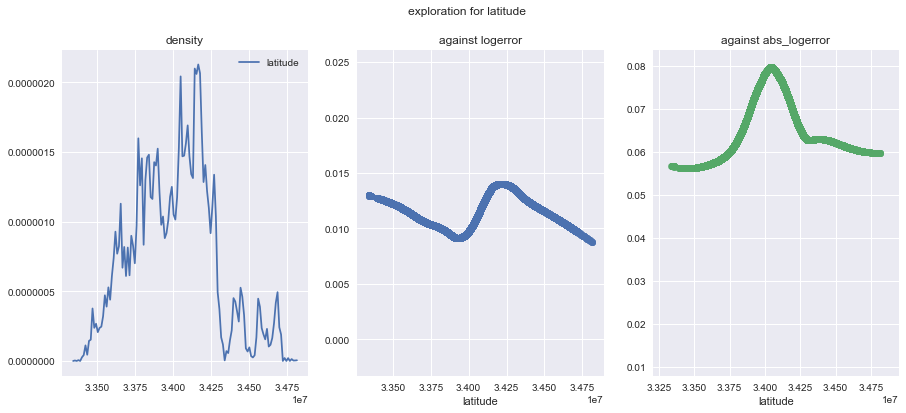

In [46]:
RENAMING_MAP['latitude'] = 'latitude'
missing_ratio('latitude')
KEEP_FEATURE.add('latitude')
visual_analysis_num('latitude')

In [47]:
# impute missing in prop data with mean.
prop_data['latitude'].fillna(prop_data['latitude'].mean(), inplace=True)

### longitude

Description: Longitude of the middle of the parcel multiplied by 10e6. Typical numerical feature. Sure to include in model

missing ratio prop: 0.0038
missing ratio train: 0.0000


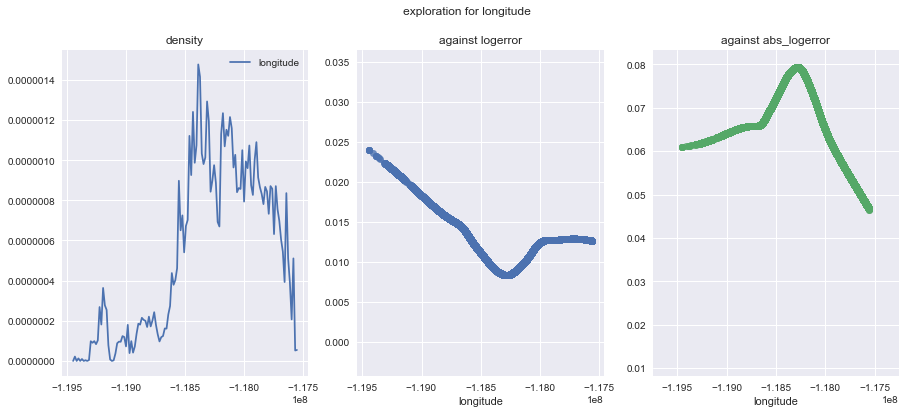

In [48]:
RENAMING_MAP['longitude'] = 'longitude'
missing_ratio('longitude')
KEEP_FEATURE.add('longitude')
visual_analysis_num('longitude')

In [49]:
# impute missing in prop data with mean.
prop_data['longitude'].fillna(prop_data['longitude'].mean(), inplace=True)

### lotsizesquarefeet

Description: Area of the lot in square feet. Numerical variable, rename to 'area_lot'.

In [50]:
RENAMING_MAP['lotsizesquarefeet'] = 'area_lot'
missing_ratio('lotsizesquarefeet')

missing ratio prop: 0.0925
missing ratio train: 0.1124


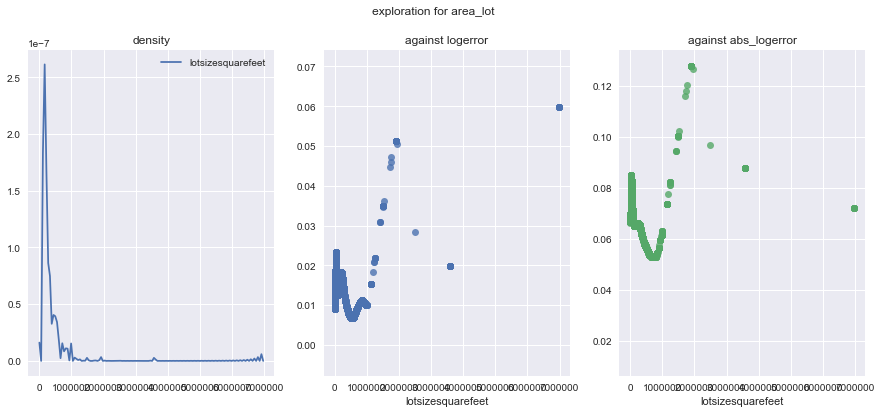

In [51]:
# low missing rate, keep it
KEEP_FEATURE.add('lotsizesquarefeet')
visual_analysis_num('lotsizesquarefeet')

### poolcnt

Description: Number of pools on the lot (if any). From train data, the recorded values are either 1 or NaN. So make if a bool categorical variable, with >=1 -> TRUE and FALSE otherwise. Apply the same to prop data. rename it to 'flag_pool'.

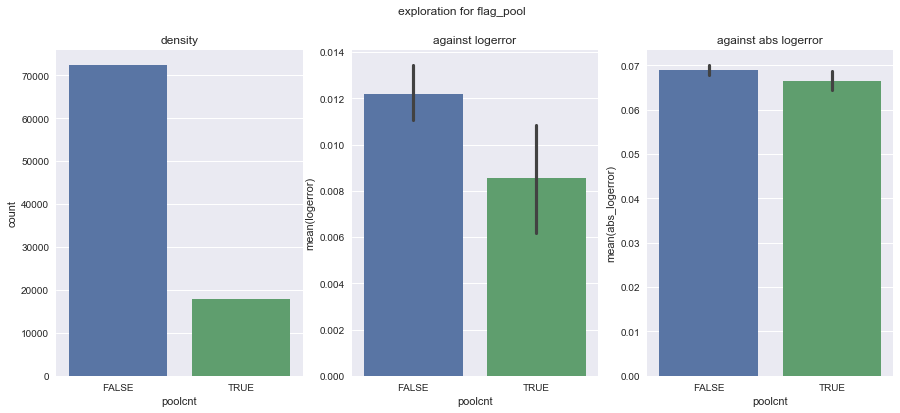

In [52]:
RENAMING_MAP['poolcnt'] = 'flag_pool'
mark_flag_col('poolcnt')
KEEP_FEATURE.add('poolcnt')
visual_analysis_cat('poolcnt')

### poolsizesum

Description: Total square footage of all pools on property. Numerical variable. Since we have marked number pool as existing or not, then flag_pool == FALSE set size to 0. leave others as nan or value given. Rename to 'area_pool'.

In [55]:
RENAMING_MAP['poolsizesum'] = 'area_pool'
prop_data.loc[prop_data.index[prop_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0
train_data.loc[train_data.index[train_data['poolcnt'] == 'FALSE'], 'poolsizesum'] = 0
missing_ratio('poolsizesum')

missing ratio prop: 0.1640
missing ratio train: 0.1876


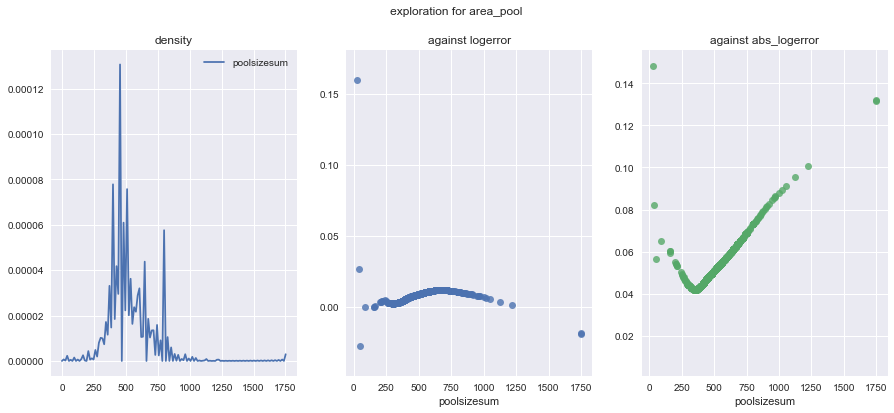

In [57]:
KEEP_FEATURE.add('poolsizesum')
visual_analysis_num('poolsizesum')

### pooltypeid10

Description: Spa or Hot Tub. Seems to be a property of pool, but none of the has-value sample shows up with a TRUE pool count. Rename it to 'type_pool_assessor'. Directly take a look at missing rate and patterns. It only has 1 or NaN, mark nan as FALSE. let's take a look at the pattern.

n consistent pool_type_10 and pool cnt: 0


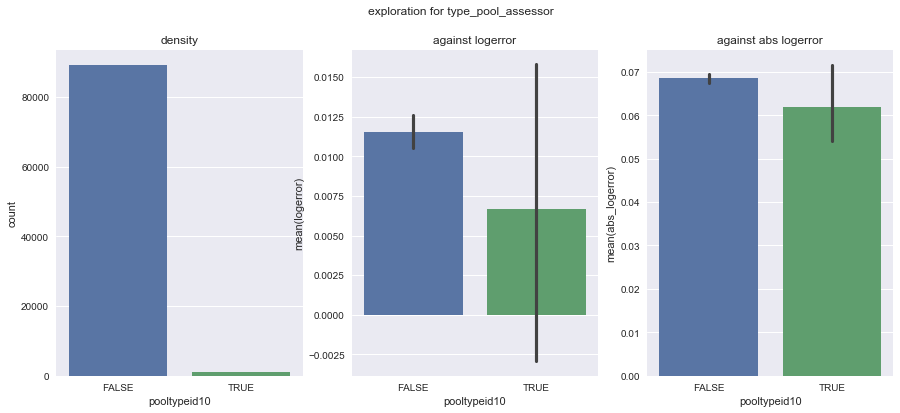

In [65]:
print('n consistent pool_type_10 and pool cnt: %d' % np.sum(np.logical_and(train_data['poolcnt'] == 'TRUE', train_data['pooltypeid10'] == 1)))
RENAMING_MAP['pooltypeid10'] = 'type_pool_assessor'
mark_flag_col('pooltypeid10')
visual_analysis_cat('pooltypeid10')

Groups too much imbalanced, meaning original missing rate was very high. Together considering the strange behavior of the feature, for sure NOT to use it for modeling

### pooltypeid2

Description: Pool with Spa/Hot Tub. So it describs details of pools. Rename to 'flag_pool_type2'. Together with next one:

### pooltypeid7

Description: Pool without hot tub. Rename to 'flag_pool_type7'.

Looks these two should be complementary and related to flag_pool.

In [68]:
# first mark names and transform features
RENAMING_MAP['pooltypeid2'] = 'flag_pool_type2'
mark_flag_col('pooltypeid2')
RENAMING_MAP['pooltypeid7'] = 'flag_pool_type7'
mark_flag_col('pooltypeid7')

In [69]:
# show flag_pool_type2 OR flag_pool_type7 == flag_pool, and flag_pool_type2 AND flag_pool_type7 == 0
flag_type2 = train_data['pooltypeid2'] == 'TRUE'
flag_type7 = train_data['pooltypeid7'] == 'TRUE'
flag_pool = train_data['poolcnt'] == 'TRUE'
print('num type2 OR type7 != pool: %d <expect 0>' % np.sum(np.logical_xor(np.logical_or(flag_type2, flag_type7), flag_pool)))
print('num type2 AND type7: %d <expect 0>' % np.sum(np.logical_and(flag_type2, flag_type7)))

num type2 OR type7 != pool: 0 <expect 0>
num type2 AND type7: 0 <expect 0>


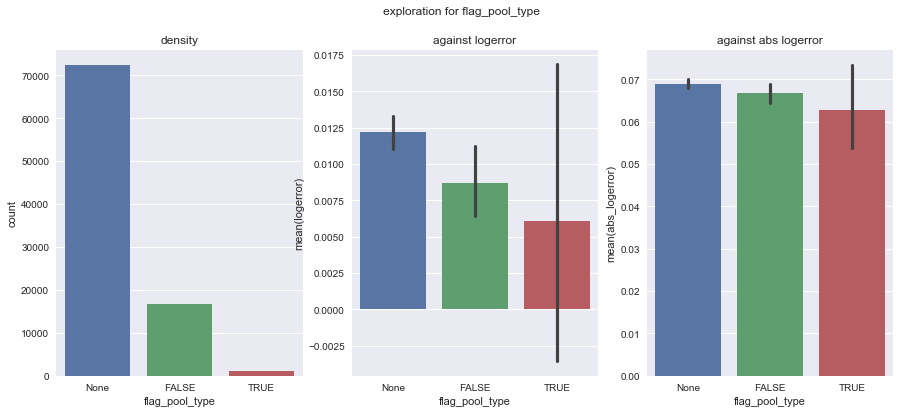

In [71]:
# It means we only need to keep one as feature, but need to make it as a new one, marking NaN as a new categroy.
def make_pool_type(data):
    data['flag_pool_type'] = 'None'
    data.loc[data.index[data['pooltypeid2'] == 'TRUE'], 'flag_pool_type'] = 'TRUE'
    data.loc[data.index[data['pooltypeid7'] == 'TRUE'], 'flag_pool_type'] = 'FALSE'

make_pool_type(prop_data)
make_pool_type(train_data)
RENAMING_MAP['flag_pool_type'] = 'flag_pool_type'
visual_analysis_cat('flag_pool_type')

Yet, from visualization, the groups size between type2 and type7 are quite imbalanced. So we drop the feature.

### propertycountylandusecode

Description: County land use code i.e. it's zoning at the county level. It is categorical, but has frightening 78 categories. Rename it to 'code_county_landuse'.

In [75]:
print('n categories: %d' % len(train_data['propertycountylandusecode'].unique()))
RENAMING_MAP['propertycountylandusecode'] = 'code_county_landuse'
missing_ratio('propertycountylandusecode')

n categories: 78
missing ratio prop: 0.0041
missing ratio train: 0.0000


In [77]:
# no missing, keep it as candidate, hope LightGBM can handle the many-category case. Meanwhile mark prop_data missings as mode
KEEP_FEATURE.add('propertycountylandusecode')
prop_data['propertycountylandusecode'].fillna(prop_data['propertycountylandusecode'].mode()[0], inplace=True)

### propertylandusetypeid

Description: Type of land use the property is zoned for. Categorical again, but appeared as numerical. Rename it to 'type_landuse'.

In [78]:
RENAMING_MAP['propertylandusetypeid'] = 'type_landuse'
print('data type:' + str(prop_data['propertylandusetypeid'].dtype))
cat_num_to_str('propertylandusetypeid')
cat_feature_analysis('propertylandusetypeid')
missing_ratio('propertylandusetypeid')

data type:float64
vals from train_data: 246, 247, 248, 260, 261, 263, 264, 265, 266, 267, 269, 275, 31, 47
n_vals from train_data: 14
vals in prop not in train: 270
n_vals in prop not in train: 1
ratio sample with val in prop not in train: 0.000012
missing ratio prop: 0.0038
missing ratio train: 0.0000


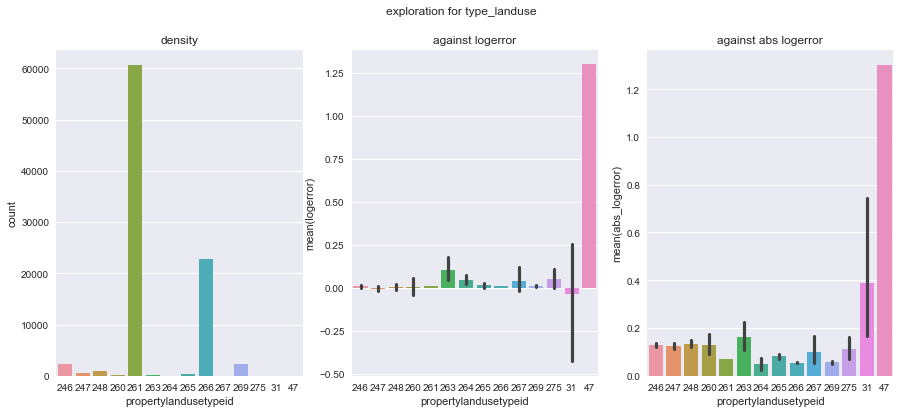

In [79]:
# clear-not-in-train as nan then impute prop data with mode. 
prop_data['propertylandusetypeid'].loc[prop_data['propertylandusetypeid'].index[prop_data['propertylandusetypeid'] == '270']] = np.nan
prop_data['propertylandusetypeid'].fillna(prop_data['propertylandusetypeid'].mode()[0], inplace=True)
KEEP_FEATURE.add('propertylandusetypeid')
visual_analysis_cat('propertylandusetypeid')

### propertyzoningdesc

Description: Description of the allowed land uses (zoning) for that property. Categorical, with 1997 categories, let's skip it.

In [82]:
print('n categories: %d' % len(train_data['propertyzoningdesc'].unique()))
RENAMING_MAP['propertyzoningdesc'] = 'str_zoning_desc'
missing_ratio('propertyzoningdesc')

n categories: 1997
missing ratio prop: 0.3372
missing ratio train: 0.3541


### rawcensustractandblock

Description: Census tract and block ID combined - also contains blockgroup assignment by extension. It is a combination of categorical information, but presented as float numerical:
1, first 4 digits is FIPS, just drop it.
2, next 6 digits, splitted by a dot, it census tract.
3, last 4 digits I assume it is block ID.
Let's create new features from it, as census_raw and block_raw.

In [89]:
missing_ratio('rawcensustractandblock')
print(train_data['rawcensustractandblock'].dtype)
def raw_census_info_split(data):
    data['temp'] = data['rawcensustractandblock'].apply(lambda x: str(round(x * 1000000)) if not np.isnan(x) else 'nan')
    data['temp'] = data['temp'].astype('O')
    data['raw_census'] = data['temp'].apply(lambda x: x[4:10] if not x == 'nan' else np.nan)
    data['raw_block'] = data['temp'].apply(lambda x: x[10:] if not x == 'nan' else np.nan)
    data.drop('temp', axis=1, inplace=True)
raw_census_info_split(prop_data)
raw_census_info_split(train_data)
print('n categories raw_census: %d' % len(train_data['raw_census'].unique()))
print('n categories raw block: %d' % len(train_data['raw_block'].unique()))

missing ratio prop: 0.0038
missing ratio train: 0.0000
float64
n categories raw_census: 3002
n categories raw block: 686


In [90]:
# but need to impute for prop_data
prop_data['raw_census'].fillna(prop_data['raw_census'].mode()[0], inplace=True)
prop_data['raw_block'].fillna(prop_data['raw_block'].mode()[0], inplace=True)

### Candidate Feature Engineering thoughts

- where Zillow assessment and assessor assessment differ.
- rank_building_quality treated as categorical.
- if relationship of logerror to certain numerical feature is not monotonic, it would be better to create categorical variable from the feature for prediction. This effect should be extremely obvious for those int features.

### Candidate missing value imputation thoughts. 

- buildingqualitytypeid should be related to build year. How about the XOR missing rate.
- finishedfloor1squarefeet, check R^2 with other square-feet features.
- garagetotalsqft, can do impute for '0' on those with non_zero garagecarcnt.

In [ ]:
def feature_pair_analysis_num(col_name1, col_name2):
    """for feature at the same time evaluated by assessor and evaludated by Zillow, it worth viewing if where they diff makes contribution.
       Since we try to find pattern in sample, so only care for training data."""
    # ratio of samples that differ, include NaN def mismatch
    # visual_analysis on the diff series.
    pass

feature_pair_analysis_num('calculatedbathnbr', 'bathroomcnt')